In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


import re
import string
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import datetime as dt
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib

pd.set_option('max_colwidth', 200)
pd.options.display.max_columns = None

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
def latexify(fig_width=None, fig_height=None, columns=2):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.32 if columns==1 else 6.75 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax,twinx=False,SPINE_COLOR="gray"):
    
    if twinx:
        for spine in ['top']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom', 'right']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)
        
    else:
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [3]:
df_articles = pd.read_csv("../dataset/News_articles_dataset/News_articles_dataset.csv.gz")
df_articles.sample(5)

,media,date,url,heading,content,other.author,other.top_image,other.category,city,year,state,district,matches
17025,Hindu,2020-11-20,https://www.thehindu.com/news/cities/Delhi/aqi-likely-to-be-very-poor-in-delhi-today/article33136263.ece,AQI likely to be ‘very poor’ in Delhi today,City recorded season’s minimum temperature of 9.4°C\n\nThe air quality of Delhi and Noida deteriorated slightly and continued to be in ‘poor’ category on Thursday and Gurugram’s fell to ‘poor’ cat...,StaffReporter,https://www.thehindu.com/static/theme/default/base/img/og-image.jpg,delhi,delhi,NaN,delhi,central delhi,"{'air quality': 4.0, 'aqi': 3.0, 'pm2.5': 1.0, 'stubble burning': 1.0}"
11317,TOI,2021-01-08,http://timesofindia.indiatimes.com//city/mumbai/mumbai-beats-delhis-aqi-light-rain-likely-on-fri-sat/articleshow/80159526.cms,"Mumbai beats Delhi’s AQI, light rain likely on Fri, Sat","Mumbai: The city’s overall air quality index (AQI) on Thursday was higher compared to Delhi, according to System of Air Quality Weather Forecasting and Research’s (SAFAR) real-time monitoring. Thi...","Vinamrata Borwankar / TNN / Updated: Jan 8, 2021, 14:43 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75,overlay-toi_sw,pt-32,y_pad-40/photo.jpg",NaN,mumbai,2021.0,maharashtra,mumbai suburban,"{'air quality': 3.0, 'aqi': 7.0}"
6725,TOI,2018-07-05,http://timesofindia.indiatimes.com//city/ahmedabad/unsafe-cargo-handling-at-ports-polluting-marine-life/articleshow/64860286.cms,Unsafe cargo handling at ports polluting marine life,"AHMEDABAD: State’s nodal maritime agency, Gujarat Maritime Board (GMB) has been found guilty for causing severe air and water pollution at Bedi, Nava Bandar and associated ports in Jamnagar. The G...","Premal Balan / TNN / Updated: Jul 5, 2018, 05:15 IST","https://static.toiimg.com/thumb/msid-64862606,width-1070,height-580,imgsize-893782,resizemode-75,overlay-toi_sw,pt-32,y_pad-40/photo.jpg",NaN,ahmedabad,2018.0,gujarat,ahmedabad,{'air pollution': 1.0}
8386,TOI,2019-06-01,http://timesofindia.indiatimes.com//city/delhi/no-relief-in-sight-heatwave-to-continue/articleshow/69604594.cms,It’s 46.2°C in Delhi; no rain in sight,"Delhi recorded a maximum of 44.8°C on Friday\n\nNEW DELHI: It was another hot day in the city as the maximum temperature reached season’s highest till now — 44.8 degree Celsius at Safdarjung, whic...","TNN / Updated: Jun 1, 2019, 07:17 IST","https://static.toiimg.com/thumb/msid-69605923,width-1070,height-580,imgsize-615101,resizemode-75,overlay-toi_sw,pt-32,y_pad-40/photo.jpg",NaN,delhi,2019.0,delhi,central delhi,"{'air quality': 2.0, 'pm10': 1.0}"
11005,TOI,2020-11-16,http://timesofindia.indiatimes.com//city/chandigarh/harder-to-breathe-in-haryana-air-quality-of-six-cities-severe/articleshow/79240376.cms,Harder to breathe in Haryana: Air quality of six cities ‘severe’,Harder to breathe in Haryana: Air quality of six cities ‘severe’\nKARNAL: The air quality index (AQI) of Haryana’s in six cities again reached ‘severe’ category a day after Diwali on Sunday. Track...,"TNN / Nov 16, 2020, 08:12 IST",NaN,NewsCity Newschandigarh NewsHarder to breathe in Haryana: Air quality of six cities ‘severe’,chandigarh,2020.0,chandigarh,chandigarh,"{'air quality': 3.0, 'aqi': 2.0}"


In [4]:
len(df_articles)

17374

In [5]:
from pathlib import Path
path = "LDA/files/"
Path(path).mkdir(exist_ok=True,parents=True)

final = pd.read_csv("LDA/dominant_topic.csv.gz",index_col=0)
final['freq'] = 1 
final["date"] = pd.to_datetime(final["date"])
temp = final.merge(df_articles,left_on = "heading",right_on = "heading",how="left")
final["url"] = temp["url"]
final["city"] = temp["city"]
final

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,date,heading,freq,url,city
0,0,11.0,0.8940,"degrees, temperature, celsius, rain, minimum, record, maximum, delhi, wind, likely",mumbai celebrate cool years mumbai city witness lowest temperature season year mercury dip degrees celsius early thursdaythe city wake smogcovered morning ready goodbye officials say expect cold s...,2010-01-01,Mumbai celebrates a cool New Year's Eve at 13.4फ्C,1,http://timesofindia.indiatimes.com//city/mumbai/Mumbai-celebrates-a-cool-New-Years-Eve-at-13-4C/articleshow/5401190.cms,mumbai
1,1,2.0,0.2531,"fuel, power, diesel, emissions, emission, vehicles, petrol, cars, norms, reduce",dense lead trip power line lucknow power corporation limit keep finger cross saturday state meteorological department indicate heavy foggy condition western region statethe warn department tizzy c...,2010-01-02,Dense fog leads to tripping of power lines,1,http://timesofindia.indiatimes.com//city/lucknow/Dense-fog-leads-to-tripping-of-power-lines/articleshow/5403987.cms,lucknow
2,2,13.0,0.2555,"health, respiratory, people, cause, patients, asthma, lung, diseases, case, increase",city high level smogforming ozone chennai dangerous level groundlevel ozone cause respiratory ailments envelop chennai city like indian metros blissfully unaware absence monitor study take ramacha...,2010-01-09,City has high levels of smog-forming ozone,1,http://timesofindia.indiatimes.com//city/chennai/City-has-high-levels-of-smog-forming-ozone/articleshow/5425554.cms,chennai
3,3,10.0,0.5919,"police, team, take, work, hospital, case, die, india, death, tell",woman kid hospital inhale smoke jaipur woman kid admit city hospital condition faint smoke emanate traditional room heater incident occur shankar vihar colony gonae road sunday morning condition s...,2010-01-11,"Woman, four kids in hospital after inhaling smoke",1,http://timesofindia.indiatimes.com//city/jaipur/Woman-four-kids-in-hospital-after-inhaling-smoke/articleshow/5431588.cms,jaipur
4,4,23.0,0.4770,"level, particulate, city, matter, increase, record, metre, cubic, quality, high",high bhogi study chennai time read bhogi pollutants envelop city study central control board indicate normal days get worse neighbourhoods consider greenadyar traditionally area comparatively lo...,2010-01-13,Pollution high on Bhogi eve: Study,1,http://timesofindia.indiatimes.com//city/chennai/Pollution-high-on-Bhogi-eve-Study/articleshow/5438915.cms,chennai
...,...,...,...,...,...,...,...,...,...,...
17395,17395,4.0,0.3792,"water, mine, coal, cause, smoke, chemical, port, chemicals, metal, tobacco",naval dockyard team repair oxygen plant nellore srikalahasti oxygen supply get boost state pandemicteams naval dockyard visakhapatnam achieve major breakthrough repair major oxygen plant nellore s...,2021-05-16,Naval Dockyard teams repair two oxygen plants in Nellore and Srikalahasti,1,https://www.thehindu.com/news/national/andhra-pradesh/naval-dockyard-teams-repair-two-oxygen-plants-in-nellore-and-srikalahasthi/article34572309.ece,visakhapatnam
17396,17396,20.0,0.4754,"project, government, crore, state, plan, development, fund, meet, propose, land",green relook silverline implementation kerala paristhithi aikya vedi forum urge chief minister pinarayi vijayan withdraw hurriedly execute semihigh speed railway project silverlinethe government f...,2021-05-24,Greens call for a relook into SilverLine implementation,1,https://www.thehindu.com/news/national/kerala/greens-call-for-a-relook-into-silverline-implementation/article34634767.ece,thiruvananthapuram
17397,17397,24.0,0.4006,"company, build, market, design, technology, mask, instal, launch, help, work",cftris ozonebased disinfection combat droplet infections csircentral food technological research institute cftri mysuru come ozonebased disinfection combat transmission droplet infections like ozo...,2021-05-25,CFTRI’s ozone-based air disinfection system to combat droplet infections,1,https://www.thehindu.com/

In [6]:
import pickle
corpus_list = pickle.load(open("LDA/LDA-25-200-alldata.pickle","rb"))
corpus_list[:6]

[[(0, 0.04962283), (11, 0.893961), (18, 0.050840937)],
 [(2, 0.25312424),
  (8, 0.06554247),
  (10, 0.094449624),
  (11, 0.23136246),
  (12, 0.131322),
  (16, 0.13094117),
  (23, 0.08658438)],
 [(5, 0.24445632),
  (9, 0.05622677),
  (13, 0.25555125),
  (22, 0.22276776),
  (23, 0.21620393)],
 [(2, 0.013209456),
  (10, 0.5919308),
  (13, 0.23401205),
  (18, 0.05172585),
  (19, 0.039709322),
  (23, 0.062740676)],
 [(1, 0.022339605),
  (2, 0.012554037),
  (5, 0.32332495),
  (11, 0.03081114),
  (15, 0.043442372),
  (19, 0.08605452),
  (23, 0.4770502)],
 [(0, 0.21804069),
  (1, 0.087345846),
  (10, 0.073918276),
  (11, 0.15147771),
  (18, 0.11992742),
  (19, 0.039568592),
  (23, 0.30535278)]]

In [7]:
#convert corpus into list of probabilities
n_topic = 25
probs = []
for doc in corpus_list:
    temp = [np.nan]*n_topic
    for topic in doc:
        topic_no, prob = topic
        temp[topic_no] = prob
    probs.append(temp)

In [8]:
df_probs = pd.DataFrame(probs)
#df_probs = df_probs.apply(lambda x: x == x.max(), axis=1).astype(int) #select maximum probability
df_probs = (df_probs>=0.5).astype(int) # or select only >0.5 probability
print(f"{len(df_probs[df_probs.apply(lambda x:sum(x)>0,axis=1)])} - articles")
print(f"{len(df_probs[df_probs.apply(lambda x:sum(x)>=2,axis=1)])} - articles having more than 1 dominant topics")
df_probs

7513 - articles
0 - articles having more than 1 dominant topics


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17395,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17396,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17397,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17398,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
df_all_topics_prob =  df_probs.merge(final,left_index=True,right_index=True)
df_top_topics = df_all_topics_prob.groupby("date").sum()[range(25)]
df_top_topics.index = pd.to_datetime(df_top_topics.index)
df_top_topics = df_top_topics.resample("10D").mean()
df_top_topics

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
date,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.166667,0.000000,0.166667,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.166667,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2010-01-11,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.200000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2010-01-21,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.400000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2010-01-31,0.000000,0.0,0.142857,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.285714,0.000000,0.0,0.142857,0.000000,0.0,0.000000,0.285714,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2010-02-10,0.000000,0.0,0.000000,0.000000,0.0,0.333333,0.000000,0.0,0.0,0.166667,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.166667,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-13,0.100000,0.0,0.000000,0.000000,0.0,0.100000,0.000000,0.0,0.1,0.200000,0.000000,0.200000,0.0,0.000000,0.000000,0.0,0.000000,0.100000,0.000000,0.000000,0.200000,0.0,0.300000,0.000000,0.000000
2021-04-23,0.333333,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.166667,0.333333,0.0,0.000000,0.166667,0.0,0.000000,0.000000,0.000000,0.000000,0.166667,0.0,0.166667,0.000000,0.000000
2021-05-03,0.000000,0.0,0.000000,0.100000,0.0,0.000000,0.200000,0.0,0.0,0.000000,0.000000,0.400000,0.0,0.100000,0.000000,0.0,0.300000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [10]:
df_filterd = df_all_topics_prob[df_all_topics_prob.apply(lambda x:sum(x[range(25)])!=0,axis=1)]

In [11]:
import pandas as pd
from sklearn import preprocessing

# df = df_cross.copy()
df = df_top_topics
df = df.replace(np.nan,0)
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.index = df_top_topics.index
df_norm = df.copy()
df_norm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
date,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.30,0.000000,0.075758,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.185185,0.00000,0.000000,0.0,0.000000,0.00000,0.00000
2010-01-11,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.125000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.00000
2010-01-21,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.72,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.00000
2010-01-31,0.000000,0.0,0.178571,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.178571,0.000000,0.0,0.079365,0.000000,0.0,0.000000,0.197802,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.00000
2010-02-10,0.000000,0.0,0.000000,0.000000,0.0,0.666667,0.000000,0.0,0.000000,0.30,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.333333,0.0,0.000000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-13,0.125000,0.0,0.000000,0.000000,0.0,0.200000,0.000000,0.0,0.033333,0.36,0.000000,0.090909,0.0,0.000000,0.000000,0.0,0.000000,0.069231,0.000000,0.00000,0.400000,0.0,0.250000,0.00000,0.00000
2021-04-23,0.416667,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.104167,0.151515,0.0,0.000000,0.208333,0.0,0.000000,0.000000,0.000000,0.00000,0.333333,0.0,0.138889,0.00000,0.00000
2021-05-03,0.000000,0.0,0.000000,0.125000,0.0,0.000000,0.400000,0.0,0.000000,0.00,0.000000,0.181818,0.0,0.055556,0.000000,0.0,0.136364,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.00000


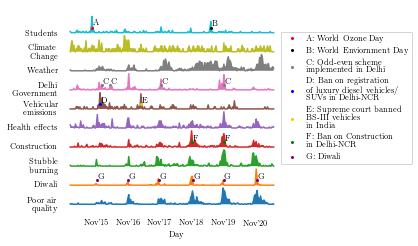

In [27]:
import datetime as dt
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (4.5,3)
fig, ax = plt.subplots()
latexify(columns=2,fig_height=3.8,fig_width=4)

date_range = pd.date_range(datetime(2015,1,1),datetime(2021,5,31))
selected_topics = [19,1,16,21,13,2,8,11,9,17]
selected_topic_labels = {
    19: "Poor air\nquality",
    1: "Diwali",
    16: "Stubble\nburning",
    21: "Construction",
    13: "Health effects",
    2: "Vehicular\nemissions", #have to check
    8: "Delhi\nGovernment",
    11: "Weather",
    9: "Climate\nChange",
    17: "Students"
}

#choose columns of seletced topics only
df = df_norm[df_norm.index.isin(date_range)][selected_topics]
cols = df.columns
fac = 0.85
x = pd.to_datetime(df.index)
for ind, col_name in enumerate(cols):
    plt.plot(x, df[col_name]+ind/fac)
    plt.fill_between(x, df[col_name]+ind/fac, ind/fac )

topics = final.drop_duplicates(subset="Dominant_Topic").nsmallest(30,"Dominant_Topic")[["Dominant_Topic","Keywords"]]
topics = topics[topics["Dominant_Topic"].isin(selected_topics)]


#set y-labels
labels = [" ".join(each.split(",")[:3]) for each in topics["Keywords"]]
labels = [selected_topic_labels[each] for each in selected_topics]
plt.yticks(np.arange(0, len(cols)*1.0/fac, 1/fac), labels)



ax = plt.gca()
# Removing spine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove x-axis label
ax.set_xlabel('Day')


plt.tick_params(
    labelsize = 8,
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True, # labels along the bottom edge are off
    left=False
)

 

# x_line_annotation = dt.datetime(2016, 4, 1)
# x_text_annotation = dt.datetime(2016, 4, 10)
# ax.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5,  color='#000000')
# ax.text(x=x_text_annotation, y=len(cols)*1.0/fac + 0.3, s='Odd Even \nAnnounced', alpha=0.7, color='#000000')
fig = plt.gcf()


# years = mdates.YearLocator()   # every year
# months = mdates.MonthLocator()  # every month
# years_fmt = mdates.DateFormatter('%b-%Y')
# ax.format_xdata = mdates.DateFormatter('%M')
# ax.xaxis.set_major_locator(years)
# ax.xaxis.set_major_formatter(years_fmt)
# ax.xaxis.set_minor_locator(months)

# fig.autofmt_xdate()


#set which month to show
ax.set_xlim(datetime(2014,11,1), datetime(2021,11,1))


#set format of date
date_form = DateFormatter("%b'%y")
#ax = fig.axes[0]
ax.xaxis.set_major_formatter(date_form)

#make interval of n months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.tick_params(axis="x",rotation=0)





events = {"World Ozone Day" : [17,[datetime(2015, 9, 16)]],
        "World Enviornment Day" : [17,[datetime(2019,6,5)]],
          "Odd-even scheme\nimplemented in Delhi":[8,[datetime(2016,1,1),datetime(2016,4,4),datetime(2017,11,13),datetime(2019,11,4)]],
         "Ban on registration\nof luxury diesel vehicles/\nSUVs in Delhi-NCR":[2,[datetime(2015,12,16)]],
          "Supreme court banned\nBS-III vehicles\nin India":[2,[datetime(2017,3,28)]],
          "Ban on Construction\nin Delhi-NCR":[21,[datetime(2019,11,4),datetime(2018,11,1)]],
          
          #"Coldest day since\n 15 years in Delhi":[11,[datetime(2021,1,1)]],
          #"Mumbai beats Delhi's AQI":[11,[datetime(2021,1,7)]],
         "Diwali":[1,[datetime(2015,11,11),datetime(2016,10,30),datetime(2017,10,19),datetime(2018,11,7),datetime(2019,10,27),datetime(2020,11,14)]]}

asci = 65
plts = []

#"#5e6ef9","#ff28fb",
colors = ["red","black","gray","blue","#edc900","green","purple"]
for event,color in zip(events,colors):
    col,dates = events[event]
    y = selected_topics.index(col)/fac
    text = chr(asci)
    
    for each_date in dates:
        x_line_smog = each_date
        x_text_smog = x_line_smog + dt.timedelta(days=10)
        plt1 = ax.plot(x_line_smog,y+0.3,"o",color=color,label= f"{text}: {event}",markersize=2)
        if "15 years" in event:
            #print("coldest")
            ax.text(x=x_text_smog, y= y+0.2, s = text, alpha=1, color='#000000',label="some")
        elif "Mumbai" in event:
            #print("mumbai")
            ax.text(x=x_text_smog, y= y+0.6, s = text, alpha=1, color='#000000',label="some")
        else:
            ax.text(x=x_text_smog, y= y+ 0.4, s = text, alpha=1, color='#000000',label="some")
        
    plts.append(plt1[0])

    asci+=1

labs = [pl.get_label() for pl in plts]

ax = plt.gca()
ax.legend(plts,labs,bbox_to_anchor=(0.95,0.9));

#,handlelength=0, handletextpad=0,markerscale=0
# leg = ax.get_legend()
# for it in leg.legendHandles:
#     print(it.set_color('red'))
plt.draw()
ticks = ax.get_xticklabels()
ticks[0] = ""
ticks[-1] = ""
#print(ticks)
ax.set_xticklabels(ticks);

# for item in leg.legendHandles:
#     item.set_visible(False)

In [28]:
fig.savefig("../figures/fig6_topic_evolution_with_time.pdf",bbox_inches="tight")

In [14]:
events = {"World Ozone\nDay" : [17,[datetime(2015, 9, 16)]],
        "World Enviorn-\nment\nDay" : [17,[datetime(2019,6,5)]],
          "Odd-even\nimplemented\nin Delhi":[8,[datetime(2016,1,1),datetime(2016,4,4),datetime(2017,11,13),datetime(2019,11,4)]],
         "Ban on registration\nof luxury diesel\nvehicle/SUVs\nin Delhi-NCR":[2,[datetime(2015,12,16)]],
          "Supreme Court\nbanned BS-III\nvehicles in India":[2,[datetime(2017,3,28)]],
          "Ban on Construction\nin Delhi-NCR":[21,[datetime(2019,11,4),datetime(2018,11,1)]],
          
          #"Coldest day since\n 15 years in Delhi":[11,[datetime(2021,1,1)]],
          #"Mumbai beats Delhi's AQI":[11,[datetime(2021,1,7)]],
         "Diwali":[1,[datetime(2015,11,11),datetime(2016,10,30),datetime(2017,10,19),datetime(2018,11,7),datetime(2019,10,27),datetime(2020,11,14)]]}

In [15]:
for event in events:
    temp_event = event
    temp_event = temp_event.replace("\n"," ")
    temp = ""
    for i in range (0,len(temp_event),11):
        temp+= temp_event[i:i+11] + "\n"
    print(temp)

World Ozone
 Day

World Envio
rn- ment Da
y

Odd-even im
plemented i
n Delhi

Ban on regi
stration of
 luxury die
sel vehicle
/SUVs in De
lhi-NCR

Supreme Cou
rt banned B
S-III vehic
les in Indi
a

Ban on Cons
truction in
 Delhi-NCR

Diwali

